## Qiskit code for "Digital quantum simulation of bosonic systems and quantum complementarity"
### Victor P. Brasil, Diego S. Starke and Jonas Maziero
#
### $(\ast)$ Obs: simulation results may vary due to code recompilation

In [1]:
from numpy import *
import numpy as np
from qiskit import *
from qiskit_aer import AerSimulator; 
from qiskit_ibm_runtime import *
from qiskit.transpiler.preset_passmanagers import *
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.visualization import *
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
# backend = service.backend('ibm_sherbrooke')

simulator = AerSimulator()
pm = generate_preset_pass_manager(backend=simulator, optimization_level=3)
sampler = Sampler(mode = simulator) 
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots

In [2]:
def results(counts_theo:dict, counts_sim:dict, counts_exp:dict):
    
    keys_theo = sorted(counts_theo.keys())
    keys_sim = sorted(counts_sim.keys())
    keys_exp = sorted(counts_exp.keys())

    probs_counts_theo = []
    probs_counts_sim = []
    probs_counts_exp = []

    for k in range(len(keys_theo)):
        probs_counts_theo.append(round(counts_theo[keys_theo[k]] / nshots, 3))
    
    for k in range(len(keys_sim)):
        probs_counts_sim.append(round(counts_sim[keys_sim[k]] / nshots, 3))
    
    for k in range(len(keys_exp)):
        probs_counts_exp.append(round(counts_exp[keys_exp[k]] / nshots, 3))
    
    counts_label = [] 
    for j in range(len(keys_exp)):
        counts_label.append(keys_exp[j])
    
    values = arange(len(counts_label))*2
    
    fig, ax = plt.subplots(layout='constrained')

    plt.rcParams['hatch.linewidth'] = 0.5

    plt.subplot().bar(values-0.4, probs_counts_theo, color='cornflowerblue', width=0.4, label='Theoretical', 
                      hatch='///', edgecolor='black', linewidth=0)
    plt.subplot().bar(values-0.4, probs_counts_theo, color='none', width=0.4, edgecolor='cornflowerblue')
    
    plt.subplot().bar(values, probs_counts_sim, color='slateblue', width=0.4, label='Simulation', hatch='\\', edgecolor='black',
                     linewidth=0) 
    plt.subplot().bar(values, probs_counts_sim, color='none', width=0.4, edgecolor='slateblue') 
    
    plt.subplot().bar(values+0.4, probs_counts_exp, color='indigo', width=0.4, label='Experiment') 

    ax.margins(0.1)
    
    plt.xticks(rotation=45)
    
    plt.xticks(values, counts_label)
    
    for c in ax.containers:
        labels = [v if v > 0 else "" for v in c.datavalues]    
        ax.bar_label(c, labels=labels, padding=7)
    
    plt.legend(prop={'size': 12})
    
    plt.ylabel('Probability', size=14)

    return plt.show()

def add_keys(counts_sim, counts_exp):
    keys = sorted(counts_exp.keys())

    for j in range(0, len(keys)):
        if keys[j] not in counts_sim:
            counts_sim[keys[j]] = 0 
        else:
            pass

In [3]:
def XX(theta): 
    qc = QuantumCircuit(2, name=' '+r'$X \otimes X$'+' ')   
    qc.h([0,1]); qc.cx(0, 1)
    qc.rz(-2*theta, [1])
    qc.cx(0, 1); qc.h([0,1])
    return qc

def YY(theta): 
    qc = QuantumCircuit(2, name=' '+r'$Y \otimes Y$'+' ')   
    qc.sdg([0, 1]); qc.h([0, 1]); qc.cx(0, 1)
    qc.rz(-2*theta, [1])
    qc.cx(0, 1); qc.h([0, 1]); qc.s([0, 1])
    return qc

def beam_splitter():
    bs = QuantumCircuit(2, name='   '+r'$U_{BS}$'+'   ')
    bs.append(XX(pi/8), [[0], [1]])
    bs.append(YY(pi/8), [[0], [1]])
    return bs

def mirror():
    bs = QuantumCircuit(2, name='   '+r'$U_{M}$'+'   ')
    bs.append(XX(pi/4), [[0], [1]])
    bs.append(YY(pi/4), [[0], [1]])
    return bs

#
### I. Unruh's experiment circuit
### (a) regular unruh setup

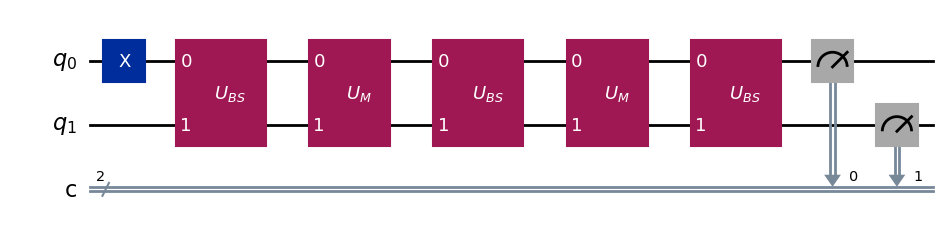

In [4]:
unruh_1 = QuantumCircuit(2, 2)
unruh_1.x(0)
unruh_1.append(beam_splitter(), [[0], [1]])
unruh_1.append(mirror(), [[0], [1]])
unruh_1.append(beam_splitter(), [[0], [1]])
unruh_1.append(mirror(), [[0], [1]])
unruh_1.append(beam_splitter(), [[0], [1]])
unruh_1.measure([0, 1], [0, 1])
unruh_1.draw('mpl')

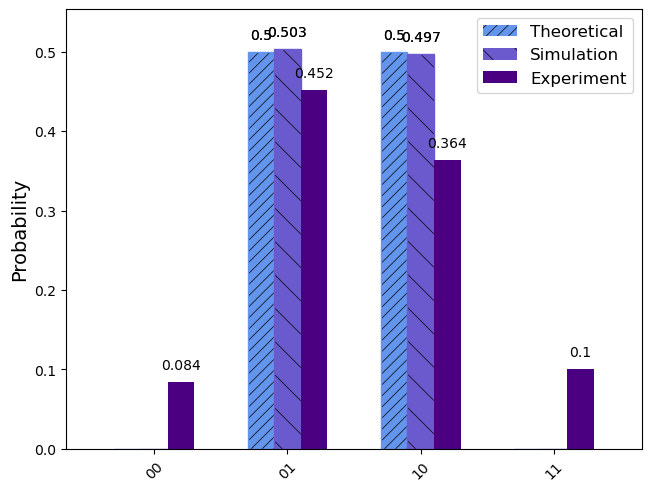

In [5]:
### simulation

qc = transpile(unruh_1, simulator, optimization_level=1)

job = sampler.run([qc]).result() 

counts = job[0].data.c.get_counts() 

counts['00'] = 0; counts['11'] = 0

### experiment

# sampler = Sampler(mode=backend)

# sampler.options.dynamical_decoupling.enable = True

# sampler.options.dynamical_decoupling.sequence_type = "XY4"

# sampler.options.default_shots = 2**13

# nshots = sampler.options.default_shots 

# job_exp_1 = sampler.run([transpile(unruh_1, backend, optimization_level=1)]).result()

# counts_exp_1 = job_exp_1[0].data.c.get_counts() 

# plot_distribution(counts_exp_1)

counts_exp_1 = service.job('cvtvkc57cb40008e3q50').result()[0].data.c.get_counts()

counts_theo_1 = {'01':2**13/2, '10':2**13/2, '00':0, '11':0}

results(counts_theo_1, counts, counts_exp_1)

#
### (b) modified Unruh setup (with phases)

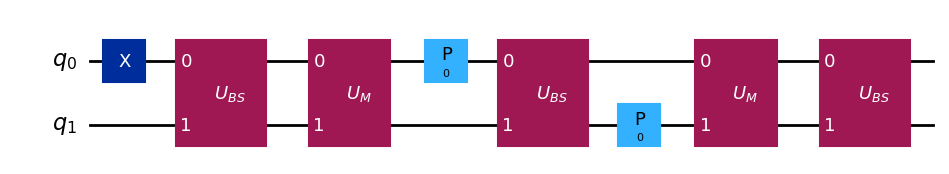

In [6]:
def unruh_phase(ph_1, ph_2):
    qc = QuantumCircuit(2)
    qc.x(0)
    qc.append(beam_splitter(), [[0], [1]])
    qc.append(mirror(), [[0], [1]])
    qc.p(ph_1, 0)
    qc.append(beam_splitter(), [[0], [1]])
    qc.p(ph_2, 1)
    qc.append(mirror(), [[0], [1]])
    qc.append(beam_splitter(), [[0], [1]])
    return qc  
unruh_phase(0, 0).draw('mpl')

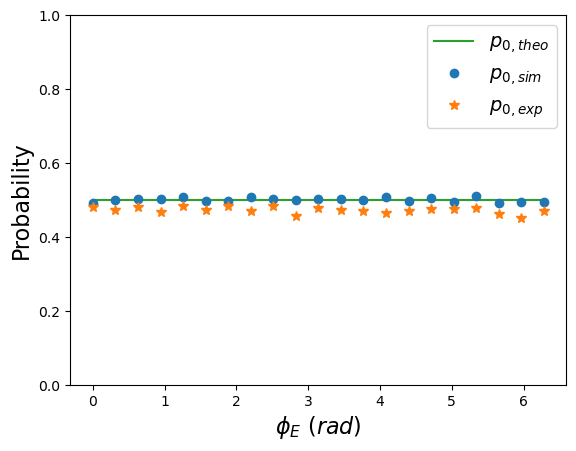

In [7]:
### simulation

ph = arange(0, 2*pi+2*pi/20, 2*pi/20)
PD0sim_2 = zeros(ph.shape[0])

sampler = Sampler(mode=simulator)
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 

for k in range(0, len(ph)):
    qc = QuantumCircuit(2, 2)
    qc.append(unruh_phase(ph[k], 0), [[0], [1]])
    qc.measure([0, 1], [0, 1])
    job_2 = sampler.run([transpile(qc, simulator, optimization_level=3)]).result()
    counts_2 = job_2[0].data.c.get_counts() 
    if '10' in counts_2:
        PD0sim_2[k] = counts_2['10']/nshots    

### experiment 

# ph = arange(0, 2*pi+2*pi/20, 2*pi/20)

# PD0_exp_2 = zeros(ph.shape[0])

# sampler = Sampler(mode=backend)

# sampler.options.default_shots = 2**13

# nshots = sampler.options.default_shots 

# for k in range(0, len(ph)):
#     qc = QuantumCircuit(2, 2)
#     unruh_exp_2 = unruh_phase(ph[k], 0)
#     qc.append(unruh_exp_2, [[0], [1]])
#     qc.measure([0, 1], [0, 1])
#     job_exp_2 = sampler.run([transpile(qc, backend, optimization_level=3)]).result()
#     counts_exp_2 = job_exp_2[0].data.c.get_counts()
#     if '10' in counts_exp_2:
#         PD0exp_2[k] = counts_exp_2['10']/nshots    

ids_exp_2 = ['cvtzd0cbm6rg008jhq70', 'cvtzdcd5sat0008hvr00', 'cvtzedshsshg008zspp0', 'cvtzex3y3grg008nfe70',
             'cvtzf647cb40008e4am0', 'cvtzfdxbtzcg008myj00', 'cvtzgq2y3grg008nfee0', 'cvtzh6c5sat0008hvrp0', 
             'cvtzhcx5sat0008hvrs0', 'cvtzhqy5sat0008hvrv0', 'cvtzjcsbtzcg008myjkg', 'cvtzk5wbtzcg008myjrg', 
             'cvtzkhpy3grg008nfevg', 'cvtzkxfbtzcg008myjvg', 'cvtzm60btzcg008myjyg', 'cvtzmesbtzcg008myjzg', 
             'cvtzmesbtzcg008myjzg', 'cvtzmqt7cb40008e4bng', 'cvtzn54hsshg008zsr00', 'cvtzned7cb40008e4bsg', 
             'cvtzntfbm6rg008jhrn0']

angles_exp_2 = []
for i in ids_exp_2:
    angles_exp_2.append(service.job(i).result()[0].data.c.get_counts())   

PD0exp_2 = []
    
for i in range(len(angles_exp_2)):
    if '10' in angles_exp_2[i]:
        PD0exp_2.append(angles_exp_2[i]['10']/nshots)
        
theo_0 = []
for j in ph:
    theo_0.append(0.5)

plt.plot(ph, theo_0, '-', label=r'$p_{0, theo}$', scaley=False, color='tab:green')
plt.plot(ph, PD0sim_2, 'o', markersize=6, label=r'$p_{0, sim}$', scaley=False, color='tab:blue')
plt.plot(ph, PD0exp_2, '*', markersize=7, label=r'$p_{0, exp}$', scaley=False, color='tab:orange')
plt.legend(prop={'size': 14})
plt.ylabel('Probability', size=16)
plt.xlabel(r'$\phi_E\ (rad)$', size=16) 
plt.show()

#

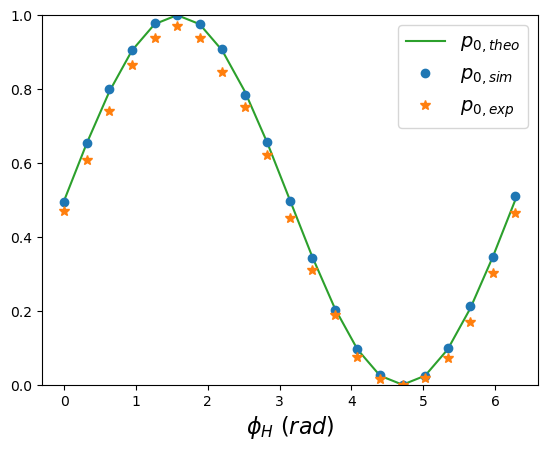

In [16]:
### simulation

ph = arange(0, 2*np.pi+2*np.pi/20, 2*np.pi/20)
PD0sim_3 = zeros(ph.shape[0])

sampler = Sampler(mode=simulator)
sampler.options.default_shots = 2**13
nshots = sampler.options.default_shots 

for k in range(0, len(ph)):
    qc_3 = QuantumCircuit(2, 2)
    qc_3.append(unruh_phase(pi/2, ph[k]), [[0], [1]])
    qc_3.measure([0, 1], [0, 1])
    job_3 = sampler.run([transpile(qc_3, simulator, optimization_level=3)]).result()
    counts_3 = job_3[0].data.c.get_counts() 
    if '10' in counts_3:
        PD0sim_3[k] = counts_3['10']/nshots

### experiment

# import numpy as np
# phmax = 2*math.pi; npe = 20; dth = phmax/npe; ph = np.arange(0,phmax+dth,dth); d = ph.shape[0]
# PD0sim2 = np.zeros(d)
# for k in range(0,len(ph)):
#     qc = QuantumCircuit(2,2)
#     unruh_p2 = unruh_phase2(ph[k])
#     qc.append(unruh_p2, [[0], [1]])
#     qc.measure(0,0)
#     qc.measure(1,1)
#     sampler = Sampler(mode=backend)
#     sampler.options.dynamical_decoupling.enable = True
#     sampler.options.dynamical_decoupling.sequence_type = "XY4"
#     sampler.options.default_shots = 2**13
#     nshots = sampler.options.default_shots 
#     job = sampler.run([transpile(qc, backend, optimization_level=3)]).result()
#     counts = job[0].data.c.get_counts() 
#     if '10' in counts:
#         PD0sim2[k] = counts['10']/nshots 

ids_exp_3 = ['cvtd491gqw30008k8ye0', 'cvtd3v7gqw30008k8ycg', 'cvtd3dxgqw30008k8yb0', 'cvtd314709200088j9w0', 'cvtd2fhx1h0g0082qc60',
             'cvtd13wgqw30008k8y6g', 'cvtd0gaw07b0008m77h0', 'cvtczwqw07b0008m77fg', 'cvtcxvfafs80008s5a80', 'cvtcwvvx1h0g0082qbx0',
             'cvtcvc5w07b0008m7790', 'cvtctchafs80008s5a4g', 'cvtcrx3709200088j9fg', 'cvtcqcx709200088j9dg', 'cvtcp7gqgh400088mvxg',
             'cvtcn3c709200088j980', 'cvtckvqafs80008s59vg', 'cvtcjvbx1h0g0082qbeg', 'cvtcgcsgqw30008k8xhg', 'cvtca20709200088j8qg', 
             'cvtajz3qgh400088ms60']; ids_exp_3 = ids_exp_3[::-1]

angles_exp_3 = []
for i in ids_exp_3:
    angles_exp_3.append(service.job(i).result()[0].data.c.get_counts())   

PD0exp_3 = []
    
for i in range(len(angles_exp_3)):
    if '10' in angles_exp_3[i]:
        PD0exp_3.append(angles_exp_3[i]['10']/nshots)

theo_1 = []
for j in ph:
    theo_1.append((1+np.sin(j))/2)

plt.plot(ph, theo_1, '-', label=r'$p_{0, theo}$', scaley=False, color='tab:green')
plt.plot(ph, PD0sim_3, 'o', markersize=6, label=r'$p_{0, sim}$', scaley=False, color='tab:blue')
plt.plot(ph, PD0exp_3, '*', markersize=7, label=r'$p_{0, exp}$', scaley=False, color='tab:orange')
plt.legend(prop={'size': 14})
plt.ylabel('', size=16)
plt.xlabel(r'$\phi_H\ (rad)$', size=16) 
plt.show()

#
### (c) with blocker $B_0$

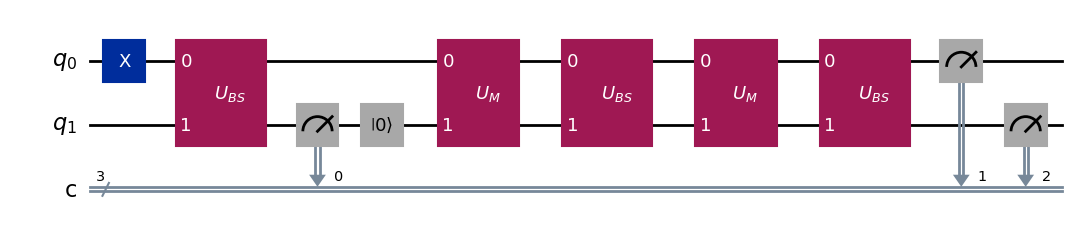

In [8]:
unruh_block_B = QuantumCircuit(2, 3)
unruh_block_B.x(0)
unruh_block_B.append(beam_splitter(), [[0], [1]])
unruh_block_B.measure(1, 0)
unruh_block_B.reset(1)
unruh_block_B.append(mirror(), [[0], [1]])
unruh_block_B.append(beam_splitter(), [[0], [1]])
unruh_block_B.append(mirror(), [[0], [1]])
unruh_block_B.append(beam_splitter(), [[0], [1]])
unruh_block_B.measure([0, 1], [1, 2])
unruh_block_B.draw('mpl')

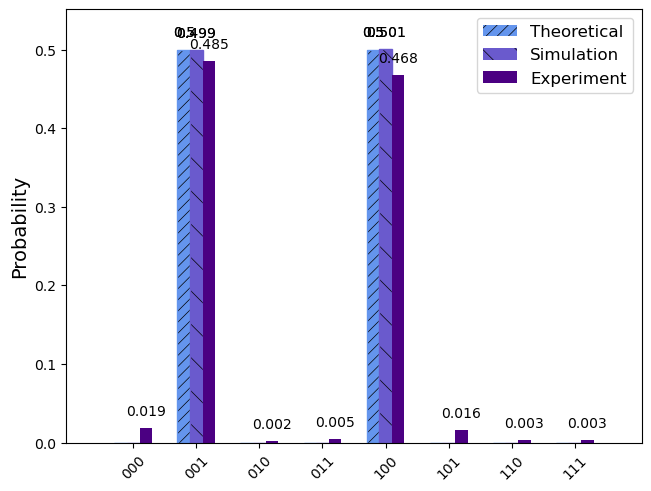

In [9]:
### simulation

unruh_block_B = transpile(unruh_block_B, simulator, optimization_level=1)

job_block_B = sampler.run([unruh_block_B]).result()

counts_block_B = job_block_B[0].data.c.get_counts() 

### experiment

# unruh_block_B_exp = transpile(unruh_block_B, backend, optimization_level=3)

# sampler = Sampler(mode=backend)

# sampler.options.dynamical_decoupling.enable = True

# sampler.options.dynamical_decoupling.sequence_type = "XY4"

# sampler.options.default_shots = 2**13

# nshots = sampler.options.default_shots 

# job_block_B_exp = sampler.run([transpile(unruh_block_B_exp, backend, optimization_level=3)]).result()

# counts_block_B_exp = job_block_B_exp[0].data.c.get_counts() 

counts_block_B_exp = service.job('cvte3myx1h0g0082qebg').result()[0].data.c.get_counts()

add_keys(counts_block_B, counts_block_B_exp)

counts_theo_2 = {'000':0, '001':2**13/2, '010':0, '011':0, '100':2**13/2, '101':0, '110':0, '111':0}

results(counts_theo_2, counts_block_B, counts_block_B_exp)

#
### (d) with blocker $B_1$

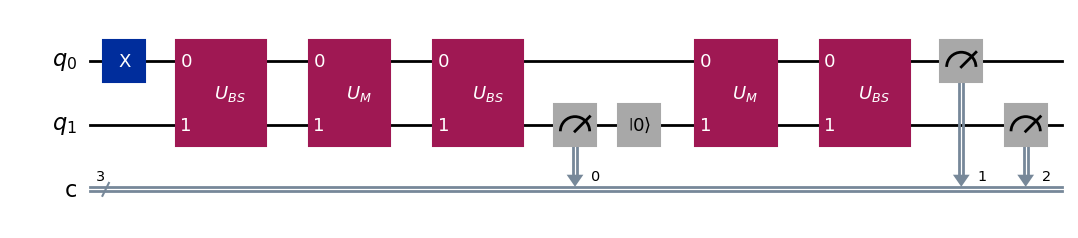

In [10]:
unruh_block2 = QuantumCircuit(2, 3)
unruh_block2.x(0)
unruh_block2.append(beam_splitter(), [[0], [1]])
unruh_block2.append(mirror(), [[0], [1]])
unruh_block2.append(beam_splitter(), [[0], [1]])
unruh_block2.measure(1, 0)
unruh_block2.reset(1)
unruh_block2.append(mirror(), [[0], [1]])
unruh_block2.append(beam_splitter(), [[0], [1]])
unruh_block2.measure([0, 1], [1, 2])
unruh_block2.draw('mpl')

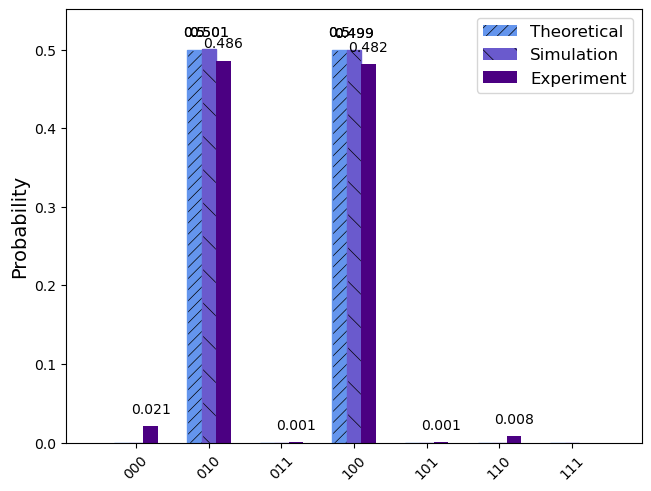

In [11]:
### simulation

unruh_block2 = transpile(unruh_block2, simulator, optimization_level=1)

job_block2 = sampler.run([unruh_block2]).result() 

counts_block2 = job_block2[0].data.c.get_counts() 

### experiment

# unruh_block2_exp = transpile(unruh_block2, backend, optimization_level=3)

# sampler = Sampler(mode=backend)

# sampler.options.dynamical_decoupling.enable = True

# sampler.options.dynamical_decoupling.sequence_type = "XY4"

# sampler.options.default_shots = 2**13

# nshots = sampler.options.default_shots 

# job_block2_exp = sampler.run([transpile(unruh_block2_exp, backend, optimization_level=3)]).result()

# counts_block2_exp = job_block2_exp[0].data.c.get_counts() 

counts_block2_exp = service.job('cvtnyybkxhv00088wkmg').result()[0].data.c.get_counts()

add_keys(counts_block2, counts_block2_exp)

counts_theo_3 = {'000':0, '010':2**13/2, '011':0, '101':0, '100':2**13/2, '110':0, '011':0, '111':0}

results(counts_theo_3, counts_block2, counts_block2_exp)

#
### (e) with blockers $B_0$ and $B_1$

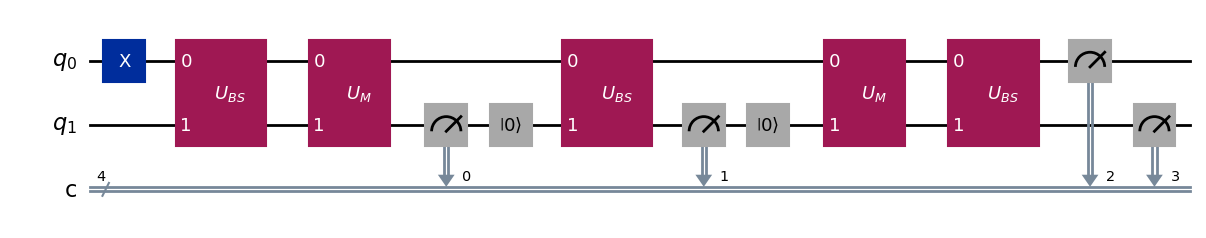

In [12]:
unruh_block3 = QuantumCircuit(2, 4)
unruh_block3.x(0)
unruh_block3.append(beam_splitter(), [[0], [1]])
unruh_block3.append(mirror(), [[0], [1]])
unruh_block3.measure(1, 0)
unruh_block3.reset(1)
unruh_block3.append(beam_splitter(), [[0], [1]])
unruh_block3.measure(1, 1)
unruh_block3.reset(1)
unruh_block3.append(mirror(), [[0], [1]])
unruh_block3.append(beam_splitter(), [[0], [1]])
unruh_block3.measure(0, 2) 
unruh_block3.measure(1, 3)
unruh_block3.draw('mpl')

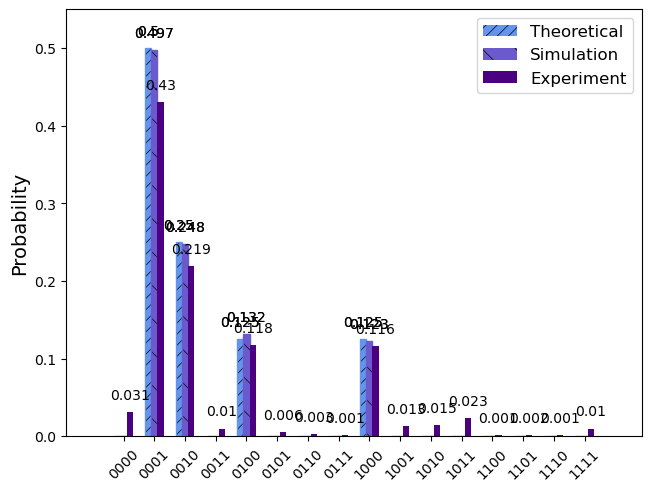

In [13]:
### simulation

unruh_block3 = transpile(unruh_block3, simulator, optimization_level=1)

job_block3 = sampler.run([unruh_block3]).result() 

counts_block3 = job_block3[0].data.c.get_counts() 

### experiment

# unruh_block3_exp = transpile(unruh_block3, backend, optimization_level=3)

# sampler = Sampler(mode=backend)

# sampler.options.dynamical_decoupling.enable = True

# sampler.options.dynamical_decoupling.sequence_type = "XY4"

# sampler.options.default_shots = 2**13

# nshots = sampler.options.default_shots 

# job_block3_exp = sampler.run([transpile(unruh_block3_exp, backend, optimization_level=3)]).result()

# counts_block3_exp = job_block3_exp[0].data.c.get_counts() 

counts_block3_exp = service.job('cvtnxhpkxhv00088wkbg').result()[0].data.c.get_counts()

counts_theo_4 = {'0000':0, '0001':2**13*0.5, '0010':2**13*0.25, '0011':0, '0100':2**13*0.125, '0101':0, '0110':0, '0111':0,
                 '1000':2**13*0.125, '1001':0, '1010':0, '1011':0, '1100':0, '1101':0, '1110':0, '1111':0}

add_keys(counts_block3, counts_block3_exp)

results(counts_theo_4, counts_block3, counts_block3_exp)

#
### II. Pessoa's experiment circuit
### (a) regular setup

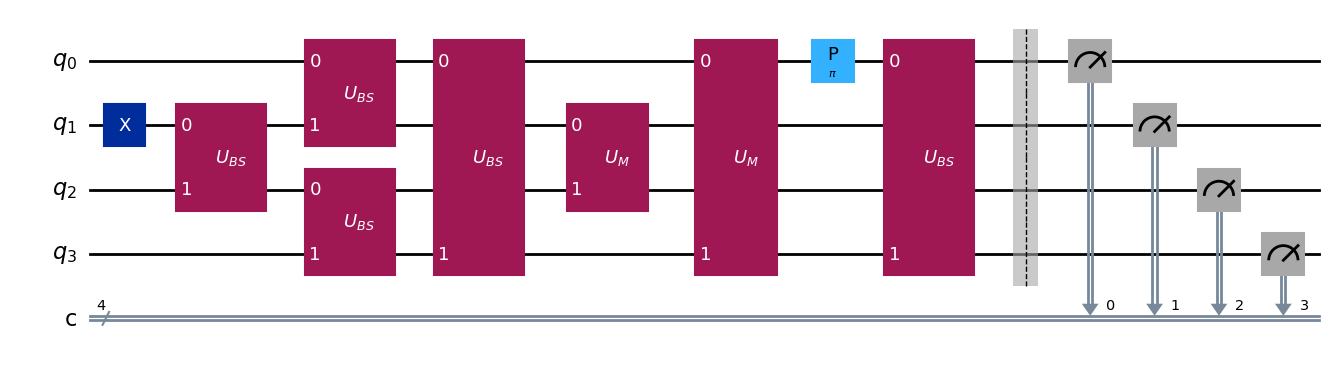

In [14]:
p_jr = QuantumCircuit(4, 4)
p_jr.x(1)
p_jr.append(beam_splitter(), [[1], [2]]) 
p_jr.append(beam_splitter(), [[0], [1]])
p_jr.append(beam_splitter(), [[2], [3]])
p_jr.append(beam_splitter(), [[0], [3]]) 
p_jr.append(mirror(), [[1], [2]]) 
p_jr.append(mirror(), [[0], [3]]) 
p_jr.p(pi, 0)
p_jr.append(beam_splitter(), [[0], [3]]) 
p_jr.barrier()
p_jr.measure([0, 1, 2, 3], [0, 1, 2, 3])
p_jr.draw('mpl')

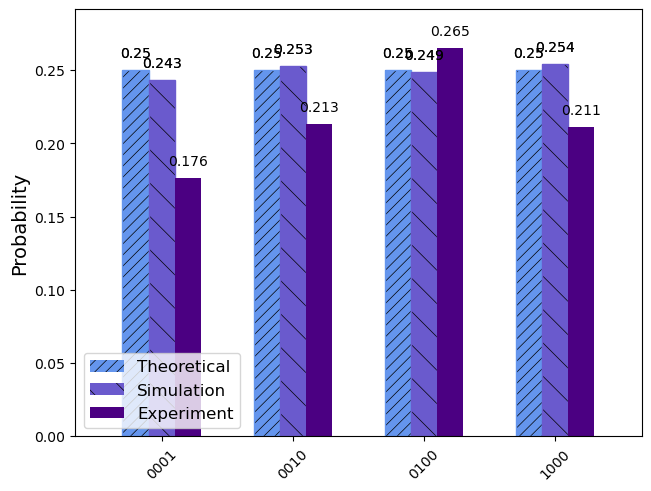

In [15]:
### simulation

p_jr = transpile(p_jr, simulator, optimization_level=1)

job_p_jr = sampler.run([p_jr]).result() 

counts_p_jr = job_p_jr[0].data.c.get_counts() 

### experiment 

# p_jr_exp = transpile(p_jr, backend, optimization_level=3)

# sampler = Sampler(mode=backend)

# sampler.options.dynamical_decoupling.enable = True

# sampler.options.dynamical_decoupling.sequence_type = "XY4"

# sampler.options.default_shots = 2**13

# nshots = sampler.options.default_shots 

# job_p_jr_exp = sampler.run([transpile(p_jr_exp, backend, optimization_level=3)]).result()

# counts_p_jr_exp = job_p_jr_exp[0].data.c.get_counts() 

counts_p_jr_exp = service.job('cw03wf1jz3x0008j4q4g').result()[0].data.c.get_counts()

### results due to experimental error; the probabilities for each result are
### included in a appendix table.
counts_p_jr_exp.pop('0000'); counts_p_jr_exp.pop('0011'); counts_p_jr_exp.pop('0101'); counts_p_jr_exp.pop('0110')
counts_p_jr_exp.pop('0111'); counts_p_jr_exp.pop('1001'); counts_p_jr_exp.pop('1010'); counts_p_jr_exp.pop('1011')
counts_p_jr_exp.pop('1100'); counts_p_jr_exp.pop('1101'); counts_p_jr_exp.pop('1110'); counts_p_jr_exp.pop('1111')

counts_theo = {'1000': 2**13/4, '0100':2**13/4, '0010':2**13/4, '0001':2**13/4}

results(counts_theo, counts_p_jr, counts_p_jr_exp)

#
### (b) with blocker $B_0$

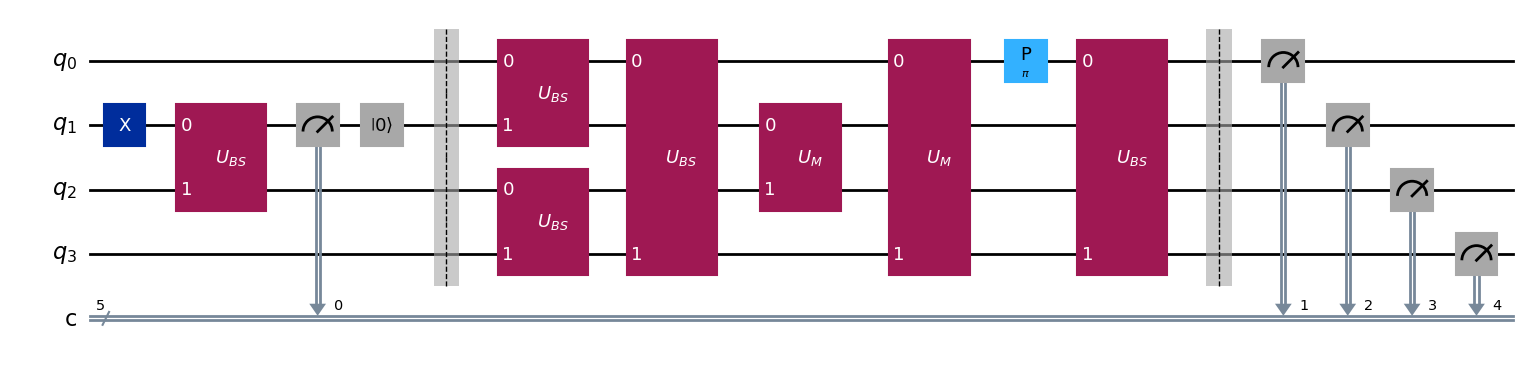

In [16]:
p_jr_A = QuantumCircuit(4, 5)
p_jr_A.x(1)
p_jr_A.append(beam_splitter(), [[1], [2]]) 
p_jr_A.measure(1, 0)
p_jr_A.reset(1)
p_jr_A.barrier()
p_jr_A.append(beam_splitter(), [[0], [1]])
p_jr_A.append(beam_splitter(), [[2], [3]])
p_jr_A.append(beam_splitter(), [[0], [3]]) 
p_jr_A.append(mirror(), [[1], [2]]) 
p_jr_A.append(mirror(), [[0], [3]]) 
p_jr_A.p(pi, 0)
p_jr_A.append(beam_splitter(), [[0], [3]]) 
p_jr_A.barrier()
p_jr_A.measure([0, 1, 2, 3], [1, 2, 3, 4])
p_jr_A.draw('mpl')

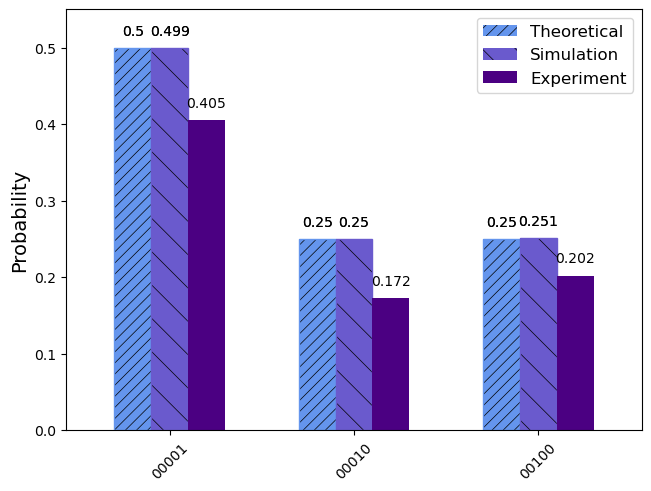

In [17]:
### simulation

p_jr_A = transpile(p_jr_A, simulator, optimization_level=1)

job_p_jr_A = sampler.run([p_jr_A]).result() 

counts_p_jr_A = job_p_jr_A[0].data.c.get_counts() 

### experiment

# p_jr_A_exp = transpile(p_jr_A, backend, optimization_level=3)

# sampler = Sampler(mode=backend)

# sampler.options.dynamical_decoupling.enable = True

# sampler.options.dynamical_decoupling.sequence_type = "XY4"

# sampler.options.default_shots = 2**13

# nshots = sampler.options.default_shots 

# job_p_jr_A_exp = sampler.run([transpile(p_jr_A_exp, backend, optimization_level=3)]).result()

# counts_p_jr_A_exp = job_p_jr_A_exp[0].data.c.get_counts() 

counts_p_jr_A_exp = service.job('cw04cn254nq0008x3mfg').result()[0].data.c.get_counts()

### results due to experimental error; the probabilities for each result are
### included in a appendix table.
counts_p_jr_A_exp.pop('00000'); counts_p_jr_A_exp.pop('00011'); counts_p_jr_A_exp.pop('00101'); counts_p_jr_A_exp.pop('00110')
counts_p_jr_A_exp.pop('00111'); counts_p_jr_A_exp.pop('01000'); counts_p_jr_A_exp.pop('01001'); counts_p_jr_A_exp.pop('01010')
counts_p_jr_A_exp.pop('01011'); counts_p_jr_A_exp.pop('01100'); counts_p_jr_A_exp.pop('01101'); counts_p_jr_A_exp.pop('01110')
counts_p_jr_A_exp.pop('01111'); counts_p_jr_A_exp.pop('10000'); counts_p_jr_A_exp.pop('10001'); counts_p_jr_A_exp.pop('10010')
counts_p_jr_A_exp.pop('10011'); counts_p_jr_A_exp.pop('10100'); counts_p_jr_A_exp.pop('10101'); counts_p_jr_A_exp.pop('10110')
counts_p_jr_A_exp.pop('10111'); counts_p_jr_A_exp.pop('11000'); counts_p_jr_A_exp.pop('11001'); counts_p_jr_A_exp.pop('11010')
counts_p_jr_A_exp.pop('11011'); counts_p_jr_A_exp.pop('11100'); counts_p_jr_A_exp.pop('11101'); counts_p_jr_A_exp.pop('11110')
counts_p_jr_A_exp.pop('11111')

counts_p_jr_A_theo = {'00001':2**13/2, '00010':2**13/4, '00100':2**13/4}

add_keys(counts_p_jr_A, counts_p_jr_A_exp)

results(counts_p_jr_A_theo, counts_p_jr_A, counts_p_jr_A_exp)

#
### (c) with blocker $B_1$

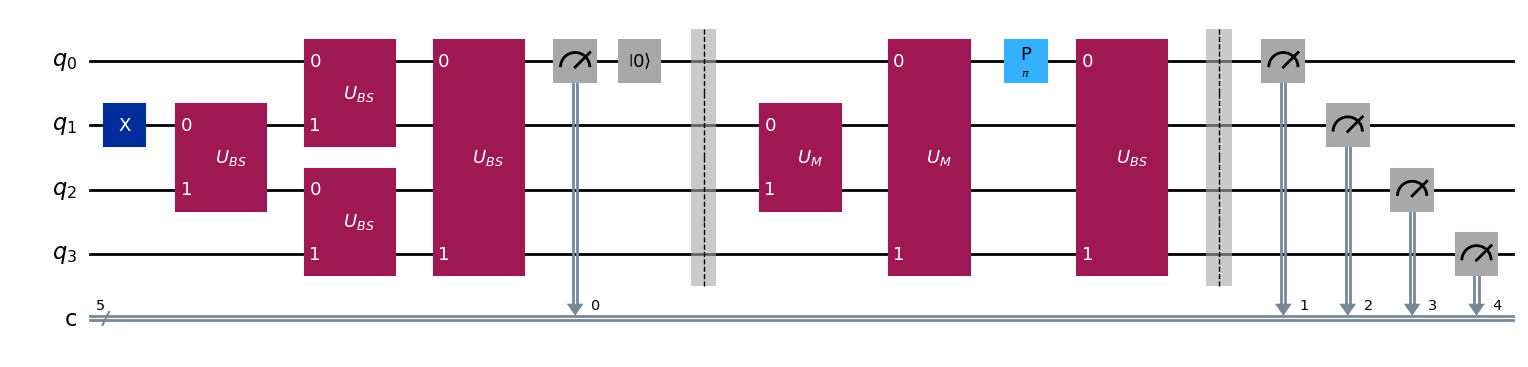

In [18]:
p_jr_B = QuantumCircuit(4, 5)
p_jr_B.x(1)
p_jr_B.append(beam_splitter(), [[1], [2]]) 
p_jr_B.append(beam_splitter(), [[0], [1]])
p_jr_B.append(beam_splitter(), [[2], [3]])
p_jr_B.append(beam_splitter(), [[0], [3]]) 
p_jr_B.measure(0, 0)
p_jr_B.reset(0)
p_jr_B.barrier()
p_jr_B.append(mirror(), [[1], [2]]) 
p_jr_B.append(mirror(), [[0], [3]]) 
p_jr_B.p(pi, 0)
p_jr_B.append(beam_splitter(), [[0], [3]]) 
p_jr_B.barrier()
p_jr_B.measure([0, 1, 2, 3], [1, 2, 3, 4])
p_jr_B.draw('mpl')

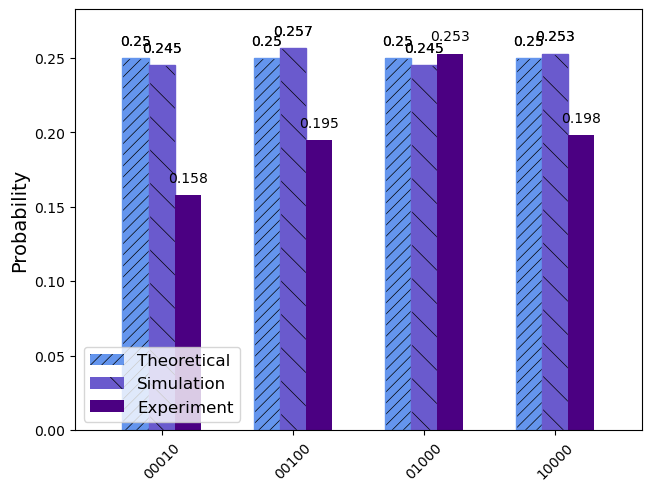

In [19]:
### simulation

p_jr_B = transpile(p_jr_B, simulator, optimization_level=1)

job_p_jr_B = sampler.run([p_jr_B]).result() 

counts_p_jr_B = job_p_jr_B[0].data.c.get_counts() 

### experiment

# p_jr_B_exp = transpile(p_jr_B, backend, optimization_level=3)

# sampler = Sampler(mode=backend)

# sampler.options.dynamical_decoupling.enable = True

# sampler.options.dynamical_decoupling.sequence_type = "XY4"

# sampler.options.default_shots = 2**13

# nshots = sampler.options.default_shots 

# job_p_jr_B_exp = sampler.run([transpile(p_jr_B_exp, backend, optimization_level=3)]).result()

# counts_p_jr_B_exp = job_p_jr_B_exp[0].data.c.get_counts()

# counts_p_jr_B_exp = service.job('cx2cgcsztp300085fesg').result()[0].data.c.get_counts()

### obtained from job 'cx2cgcsztp300085fesg':
counts_p_jr_B_exp = {'01000': 2069, '10000': 1626, '00100': 1597, '00010': 1291} 

counts_p_jr_B_theo = {'10000': 2**13/4, '01000':2**13/4, '00100':2**13/4, '00010':2**13/4}

results(counts_p_jr_B_theo, counts_p_jr_B, counts_p_jr_B_exp)

#
### (d) with blockers $B_0$ and $B_1$

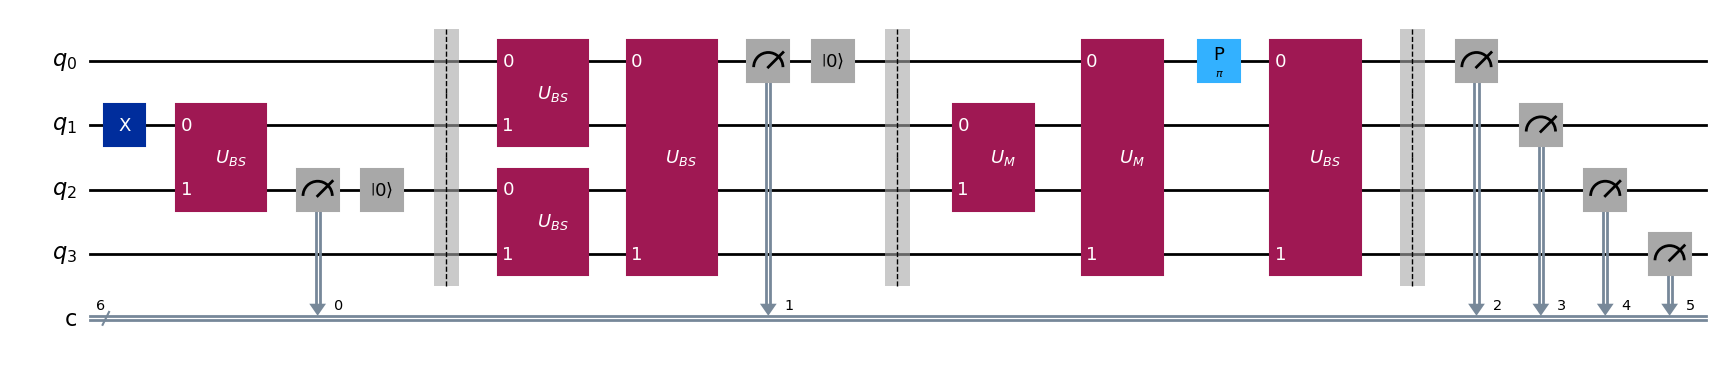

In [20]:
p_blockers = QuantumCircuit(4, 6)
p_blockers.x(1)
p_blockers.append(beam_splitter(), [[1], [2]]) 
p_blockers.measure(2, 0)
p_blockers.reset(2)
p_blockers.barrier()
p_blockers.append(beam_splitter(), [[0], [1]])
p_blockers.append(beam_splitter(), [[2], [3]])
p_blockers.append(beam_splitter(), [[0], [3]]) 
p_blockers.measure(0, 1)
p_blockers.reset(0)
p_blockers.barrier()
p_blockers.append(mirror(), [[1], [2]]) 
p_blockers.append(mirror(), [[0], [3]]) 
p_blockers.p(pi, 0)
p_blockers.append(beam_splitter(), [[0], [3]]) 
p_blockers.barrier()
p_blockers.measure([0, 1, 2, 3], [2, 3, 4, 5])
p_blockers.draw('mpl')

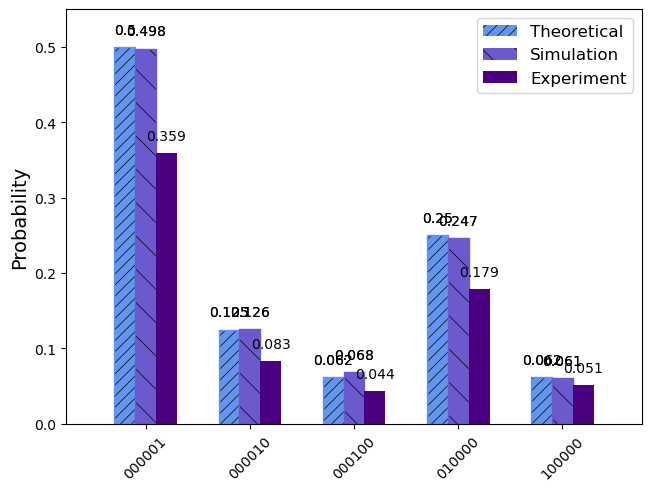

In [21]:
### simulation

p_blockers = transpile(p_blockers, simulator, optimization_level=1)

job_p_blockers = sampler.run([p_blockers]).result() 

counts_p_blockers = job_p_blockers[0].data.c.get_counts() 

### experiment 

# p_blockers_exp = transpile(p_blockers, backend, optimization_level=3)

# sampler = Sampler(mode=backend)

# sampler.options.dynamical_decoupling.enable = True

# sampler.options.dynamical_decoupling.sequence_type = "XY4"

# sampler.options.default_shots = 2**13

# nshots = sampler.options.default_shots 

# job_p_blockers_exp = sampler.run([transpile(p_blockers_exp, backend, optimization_level=3)]).result()

# counts_p_blockers_exp = job_p_blockers_exp[0].data.c.get_counts() 

#counts_p_blockers_exp = service.job('cw055xz79ws0008z0arg').result()[0].data.c.get_counts()

### obtained from job 'cw055xz79ws0008z0arg'
counts_p_blockers_experiment = {'010000': 1470, '000010': 678, '000001': 2939, '100000': 414, '000100': 359}

counts_p_blockers_theo = {'010000': 2**13*0.25, '000010': 2**13*0.125, '000001': 2**13*0.5, 
                             '100000': 2**13*0.0625, '000100': 2**13*0.0625}

results(counts_p_blockers_theo, counts_p_blockers, counts_p_blockers_experiment)

#